In [39]:
# relevant imports
from datetime import datetime
import requests
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
from fa2_modified import ForceAtlas2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import community as community_louvain 
from nltk.probability import FreqDist
from collections import defaultdict
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.dowlnoad('punkt_tab')


origin of speech data: https://data.millercenter.org/api.html

In [5]:
endpoint = "https://api.millercenter.org/speeches"
r = requests.post(url = endpoint)
data = r.json()
items = data['Items']

while 'LastEvaluatedKey' in data:
  parameters = {"LastEvaluatedKey": data['LastEvaluatedKey']['doc_name']}
  r = requests.post(url = endpoint, params = parameters)
  data = r.json()
  items.extend(data.get('Items', []))

# Save the collected items to a JSON file
with open('speeches.json', 'w') as f:
  json.dump(items, f, indent=4)

print(f'Saved {len(items)} speeches to speeches.json')

Saved 1057 speeches to speeches.json


In [68]:
# load data from the JSON file
with open('speeches.json', 'r') as f:
  speeches = json.load(f)

In [69]:
# Convert the date strings to datetime objects
for speech in speeches:
    date_str = speech['date'][:10]
    speech['date'] = datetime.strptime(date_str, '%Y-%m-%d')

# Consider only speeches after 1790, as we only have gdp data from 1790-2024
speeches = [speech for speech in speeches if speech['date'].year >= 1790]


In [70]:
# print number of speeches, presidents, time span,...
print(f'Number of speeches: {len(speeches)}')
presidents = set(speech['president'] for speech in speeches)
print(f'Number of presidents: {len(presidents)}')
speeches.sort(key=lambda x: x['date'])
print(f'Time span: {speeches[0]["date"].year} - {speeches[-1]["date"].year}')


Number of speeches: 1055
Number of presidents: 45
Time span: 1790 - 2024


In [71]:
# get text embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode([speech['transcript'] for speech in speeches])

c:\Users\Beatriz\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


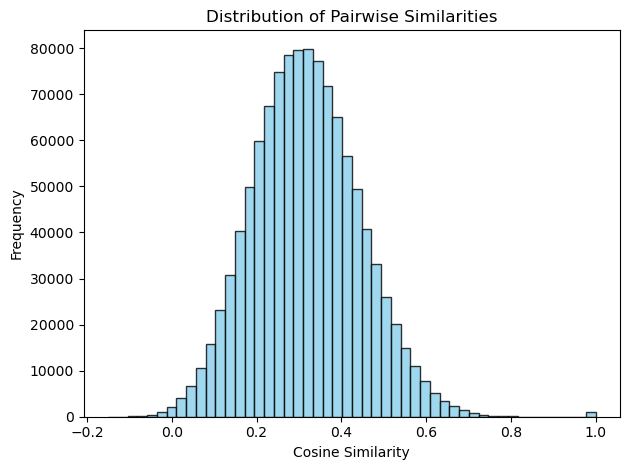

In [72]:
# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Plot bar chart
hist, bin_edges = np.histogram(similarity_matrix.flatten(), bins=50)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.bar(bin_centers, hist, width=bin_edges[1] - bin_edges[0], color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Similarities')
plt.tight_layout()
plt.show()

In [73]:
# Create a graph where nodes are speeches and edges are similarities
SpeechNet = nx.Graph()

# Add nodes with attributes (each node is a speech)
for i, speech in enumerate(speeches):
    SpeechNet.add_node(i, title=speech['title'], president=speech['president'], date=speech['date'], transcript=speech['transcript'])

# Add edges between speeches with similarity greater than 0.5
threshold = 0.6
for i in range(len(speeches)):
    for j in range(i + 1, len(speeches)):
        if similarity_matrix[i][j] > threshold:
            SpeechNet.add_edge(i, j, weight=similarity_matrix[i][j])

In [74]:
# consider largest connected component
largest_cc = max(nx.connected_components(SpeechNet), key=len)
SpeechNet = SpeechNet.subgraph(largest_cc)

In [75]:
# remove isolated nodes
SpeechNet = SpeechNet.subgraph([node for node in SpeechNet.nodes() if SpeechNet.degree(node) > 0])

In [76]:
# print node and edge counts
print(f'Numer of Nodes: {SpeechNet.number_of_nodes()}')
print(f'Number of Edges: {SpeechNet.number_of_edges()}')

Numer of Nodes: 855
Number of Edges: 8203


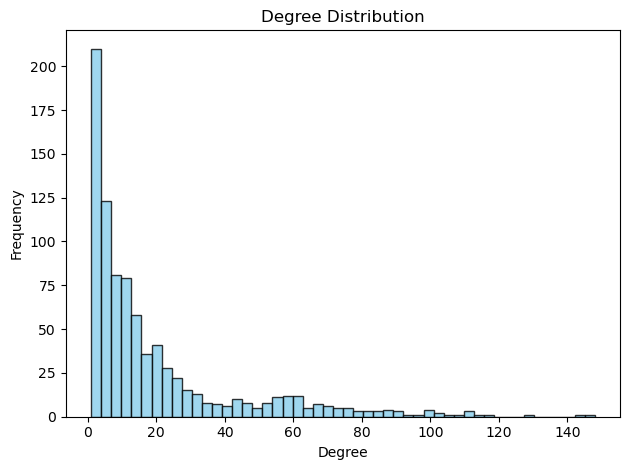

In [78]:
# plot degree distribution
degrees = [degree for node, degree in SpeechNet.degree()]
hist, bin_edges = np.histogram(degrees, bins=50)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.bar(bin_centers, hist, width=bin_edges[1] - bin_edges[0], color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.tight_layout()
plt.show()


In [79]:
# position nodes using Force Atlas 2
forceatlas2 = ForceAtlas2(verbose=False, scalingRatio=0.2)
positions = forceatlas2.forceatlas2_networkx_layout(SpeechNet, pos=None, iterations=2000)

In [80]:
from parties import president_party, party_colors
node_colors = []

# Add color to nodes based on party and party attribute to nodes
for node in SpeechNet.nodes():
    president = SpeechNet.nodes[node]['president']
    party = president_party.get(president, "None")  # Get party or default to "None"
    SpeechNet.nodes[node]['party'] = party
    color = party_colors.get(party, "gray")  # Get color based on party
    node_colors.append(color)

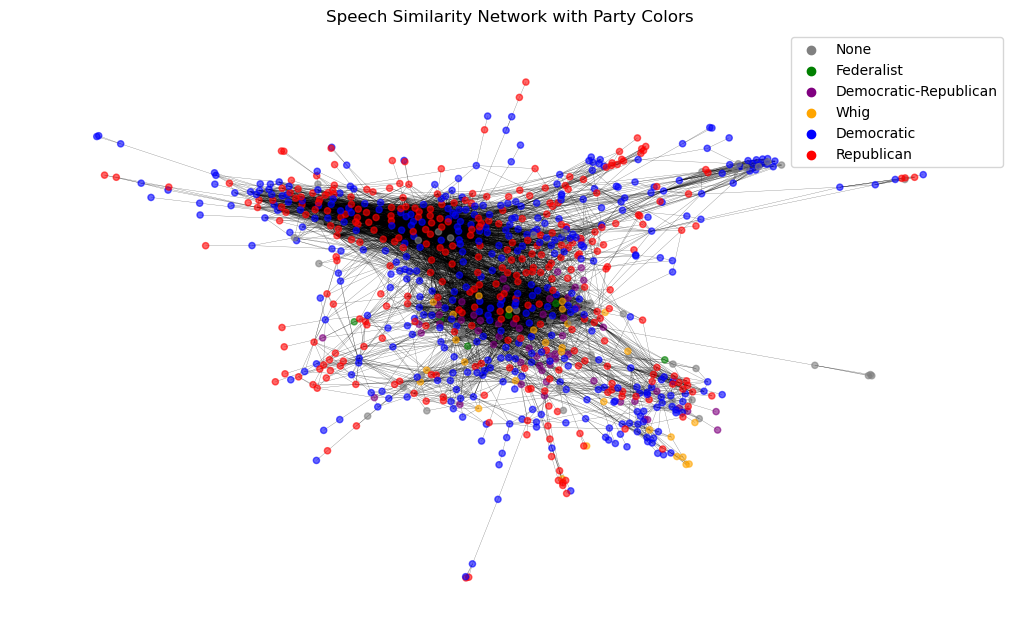

In [81]:
# plot the network 
plt.figure(figsize=(10,6))
nx.draw(SpeechNet, pos=positions, with_labels=False, node_size=20, alpha=0.6, node_color=node_colors, width=0.2)
for party, color in party_colors.items():
    plt.scatter([], [], c=color, label=party)
plt.legend(scatterpoints=1, loc='best')
plt.title('Speech Similarity Network with Party Colors')
plt.show()

In [82]:
# Create a dictionary to map parties to their respective nodes
parties_dict = {}
for node, data in SpeechNet.nodes(data=True):
    party = data.get('party')
    if party not in parties_dict:
        parties_dict[party] = []
    parties_dict[party].append(node)

# calculate modularity for parties communities
modularity = 0.0
L = SpeechNet.number_of_edges()  # Total number of edges in the graph
for genre, nodes in parties_dict.items():
    genre_subgraph = SpeechNet.subgraph(nodes)
    L_c = genre_subgraph.number_of_edges()  # Number of edges within the genre community
    K_c = sum(dict(SpeechNet.degree(nodes)).values())  # Sum of degrees of nodes within the genre community
    modularity += (L_c / L) - ((K_c / (2 * L)) ** 2)
print(f'Modularity considering parties: {modularity}')

Modularity considering parties: 0.06192784195159731


In [83]:
# calculate modularity for louvain communities
louvain_partition = community_louvain.best_partition(SpeechNet)
nx.set_node_attributes(SpeechNet, louvain_partition, 'louvain_community')
louvain_modularity = community_louvain.modularity(louvain_partition, SpeechNet)
print(f"Louvain modularity: {louvain_modularity}")


Louvain modularity: 0.49881904977439967


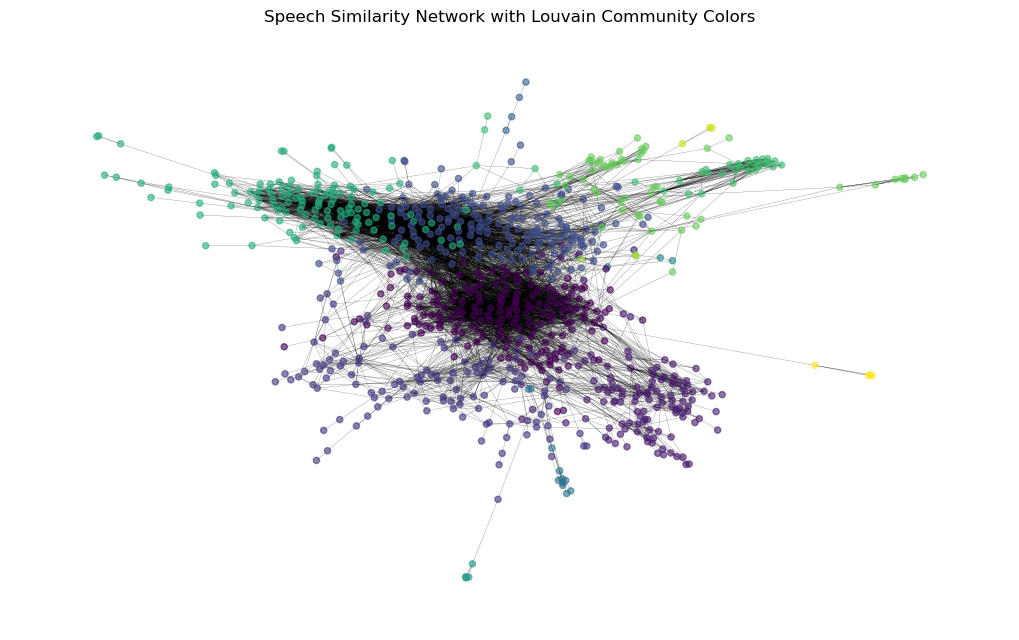

In [102]:
# plot the network 
node_colors = [louvain_partition[node] for node in SpeechNet.nodes()]
plt.figure(figsize=(10,6))
nx.draw(SpeechNet, pos=positions, with_labels=False, node_size=20, alpha=0.6, node_color=node_colors, width=0.2)
plt.title('Speech Similarity Network with Louvain Community Colors')
plt.show()

speech sentiment analysis

In [85]:
# download sentiment wordlist
with open('Data_Set_S1.txt', 'r') as f:
    data_S1 = f.read()

data_S1 = [line.split('\t') for line in data_S1.strip().split('\n')]
data_S1 = data_S1[3:]
data_S1 = pd.DataFrame(data_S1[1:], columns = data_S1[0])

In [86]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_text(text):
    """
    Process the text by tokenizing, removing punctuation, setting to lowercase, removing stopwords, and lemmatizing.
    """
    # tokenize text
    words = word_tokenize(text)
    # remove punctuation
    words = [word for word in words if word.isalpha()]
    # set to lowercase
    words = [word.lower() for word in words]
    # remove stopwords
    words = [word for word in words if word not in stop_words]
    # lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    return words   



In [87]:
def sentiment_score(text):
    """
    Calculate the sentiment score of the text based on the sentiment wordlist.
    """
    # process text to get words
    words = process_text(text)
    freq_dist = FreqDist(words)
    # calculate sentiment score
    score = sum(freq_dist[word] *float(data_S1[data_S1['word']==word]['happiness_average'].values[0]) 
                for word in freq_dist if word in data_S1['word'].values)
    total_frequency = sum(freq_dist[word] for word in freq_dist if word in data_S1['word'].values)
    
    if total_frequency > 0:  # to avoid division by zero
        return score / total_frequency
    else:
        return 0.0

In [32]:
# sentiment for every node's transcript
sentiments = {}
for speech in SpeechNet.nodes(data=True):
    name = speech[1]['title']
    transcript = speech[1]['transcript']
    sentiments[name] = sentiment_score(transcript)

In [88]:
# save the sentiment scores to a file
with open('sentiments.txt', 'w') as f:
    for speech, sentiment in sentiments.items():
        f.write(f"{speech} | {sentiment}\n")

In [89]:
# read sentiment scores from file
sentiments = {}
with open('sentiments.txt', 'r') as f:
    for line in f:
        speech, sentiment = line.strip().split(' | ')
        sentiments[speech] = float(sentiment)

# assign sentiment scores to nodes
nx.set_node_attributes(SpeechNet, sentiments, 'sentiment')

In [90]:
# average sentiment
average_sentiment = sum(sentiments.values()) / len(sentiments)
print(f"Average sentiment of the speeches: {average_sentiment}")

# median sentiment
median_sentiment = np.median(list(sentiments.values()))
print(f"Median sentiment of the speeches: {median_sentiment}")

# variance of sentiment
variance_sentiment = np.var(list(sentiments.values()))
print(f"Variance of sentiment of the speeches: {variance_sentiment}")

# 25th percentile of sentiment
percentile_25 = np.percentile(list(sentiments.values()), 25)
print(f"25th percentile of sentiment of the speeches: {percentile_25}")

# 75th percentile of sentiment
percentile_75 = np.percentile(list(sentiments.values()), 75)
print(f"75th percentile of sentiment of the speeches: {percentile_75}")

Average sentiment of the speeches: 5.635523628813007
Median sentiment of the speeches: 5.62695535315823
Variance of sentiment of the speeches: 0.01843974747874223
25th percentile of sentiment of the speeches: 5.557840126291622
75th percentile of sentiment of the speeches: 5.711700539296695


<Figure size 1000x500 with 0 Axes>

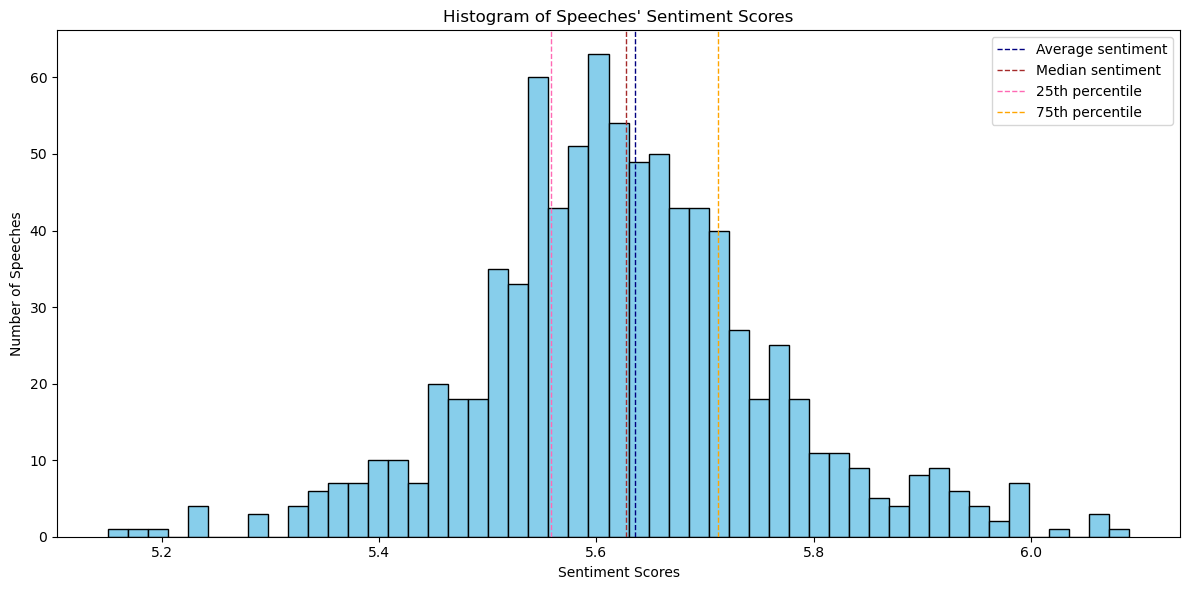

In [91]:
# plot of sentiment distribution 

plt.figure(figsize=(10, 5))

# Create bins for the sentiment scores
min_sentiment = min(sentiments.values())
max_sentiment = max(sentiments.values())
v = np.arange(min_sentiment, max_sentiment + variance_sentiment, variance_sentiment)  

# Count the number of artists in each bin
sentiment_values = list(sentiments.values())
binned_counts, bin_edges = np.histogram(sentiment_values, bins=v)

# bar plot for the histogram
plt.figure(figsize=(12, 6))
plt.bar(bin_edges[:-1], binned_counts, width=np.diff(bin_edges), color='skyblue', edgecolor='black')
# average sentiment line
plt.axvline(average_sentiment, color='navy', linestyle='dashed', linewidth=1)
# median sentiment line
plt.axvline(median_sentiment, color='brown', linestyle='dashed', linewidth=1)
# 25th percentile line
plt.axvline(percentile_25, color='hotpink', linestyle='dashed', linewidth=1)
# 75th percentile line
plt.axvline(percentile_75, color='orange', linestyle='dashed', linewidth=1)
plt.legend(['Average sentiment', 'Median sentiment', '25th percentile', '75th percentile'])
plt.title('Histogram of Speeches\' Sentiment Scores')
plt.xlabel('Sentiment Scores')
plt.ylabel('Number of Speeches')

plt.tight_layout()
plt.show()


In [92]:
# create tf lists for each speech's transcript
tf_speech = {}
for speech in speeches:
    text = speech['transcript']
    words = process_text(text)
    tf_speech[speech['title']] = pd.Series(words).value_counts()

In [93]:
# Calculate document frequency for each word
doc_freq = defaultdict(int)
for tf in tf_speech.values():
    for word in tf.index:
        doc_freq[word] += 1

# Calculate IDF for each word
idf_speech = {word: np.log(len(tf_speech) / df) for word, df in doc_freq.items()}

In [94]:
# Calculate TF-IDF for each speech
tfidf_speech = {}
for speech, tf in tf_speech.items():
    tfidf_speech[speech] = {word: tf[word] * idf_speech[word] for word in tf.index}

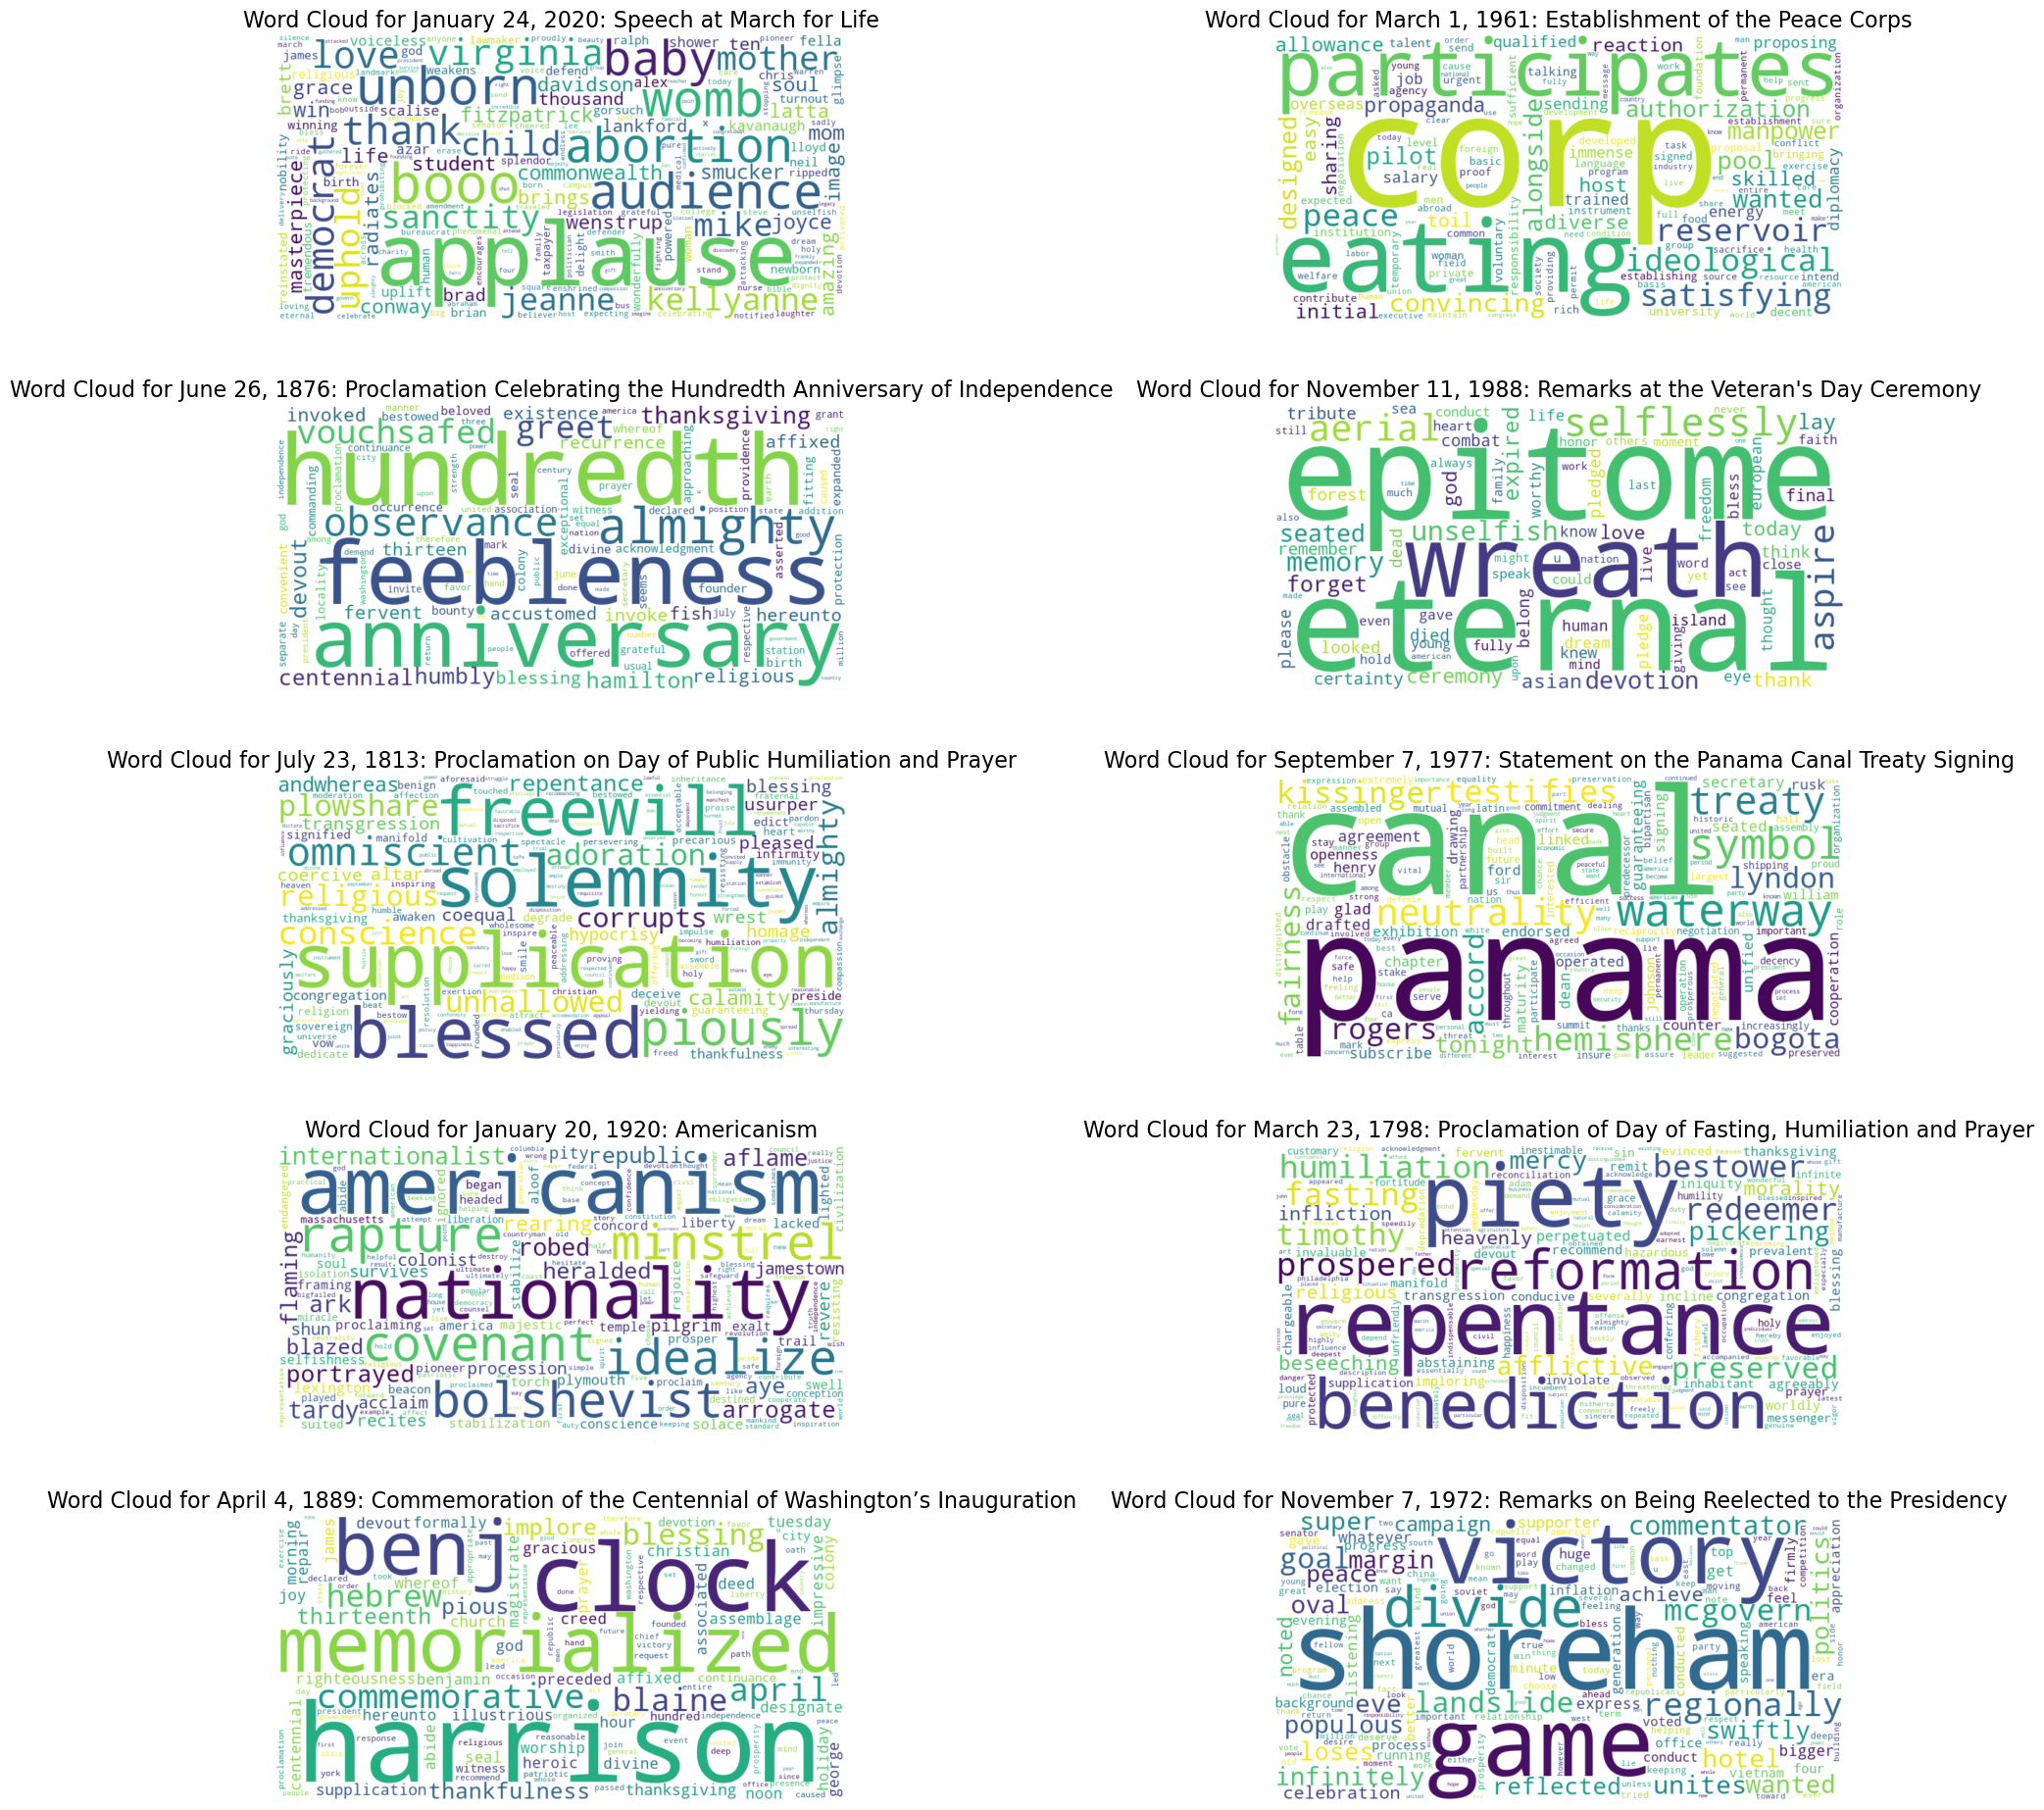

In [95]:
# Get the top 10 happiest speeches
happiest_speeches = sorted(sentiments, key=sentiments.get, reverse=True)[:10]

# Filter the tfidf_speech dictionary to include only the top 10 happiest speeches
top_tfidf_speeches = {speech: tfidf_speech[speech] for speech in happiest_speeches}

# Create word clouds for the top 10 happiest speeches
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
for i, (speech, tfidf) in enumerate(top_tfidf_speeches.items()):
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, collocations=False, background_color='white').generate_from_frequencies(tfidf)
    ax = plt.subplot(5, 2, i + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"Word Cloud for {speech}", fontsize=16)

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.3, wspace=0.3)
plt.show()

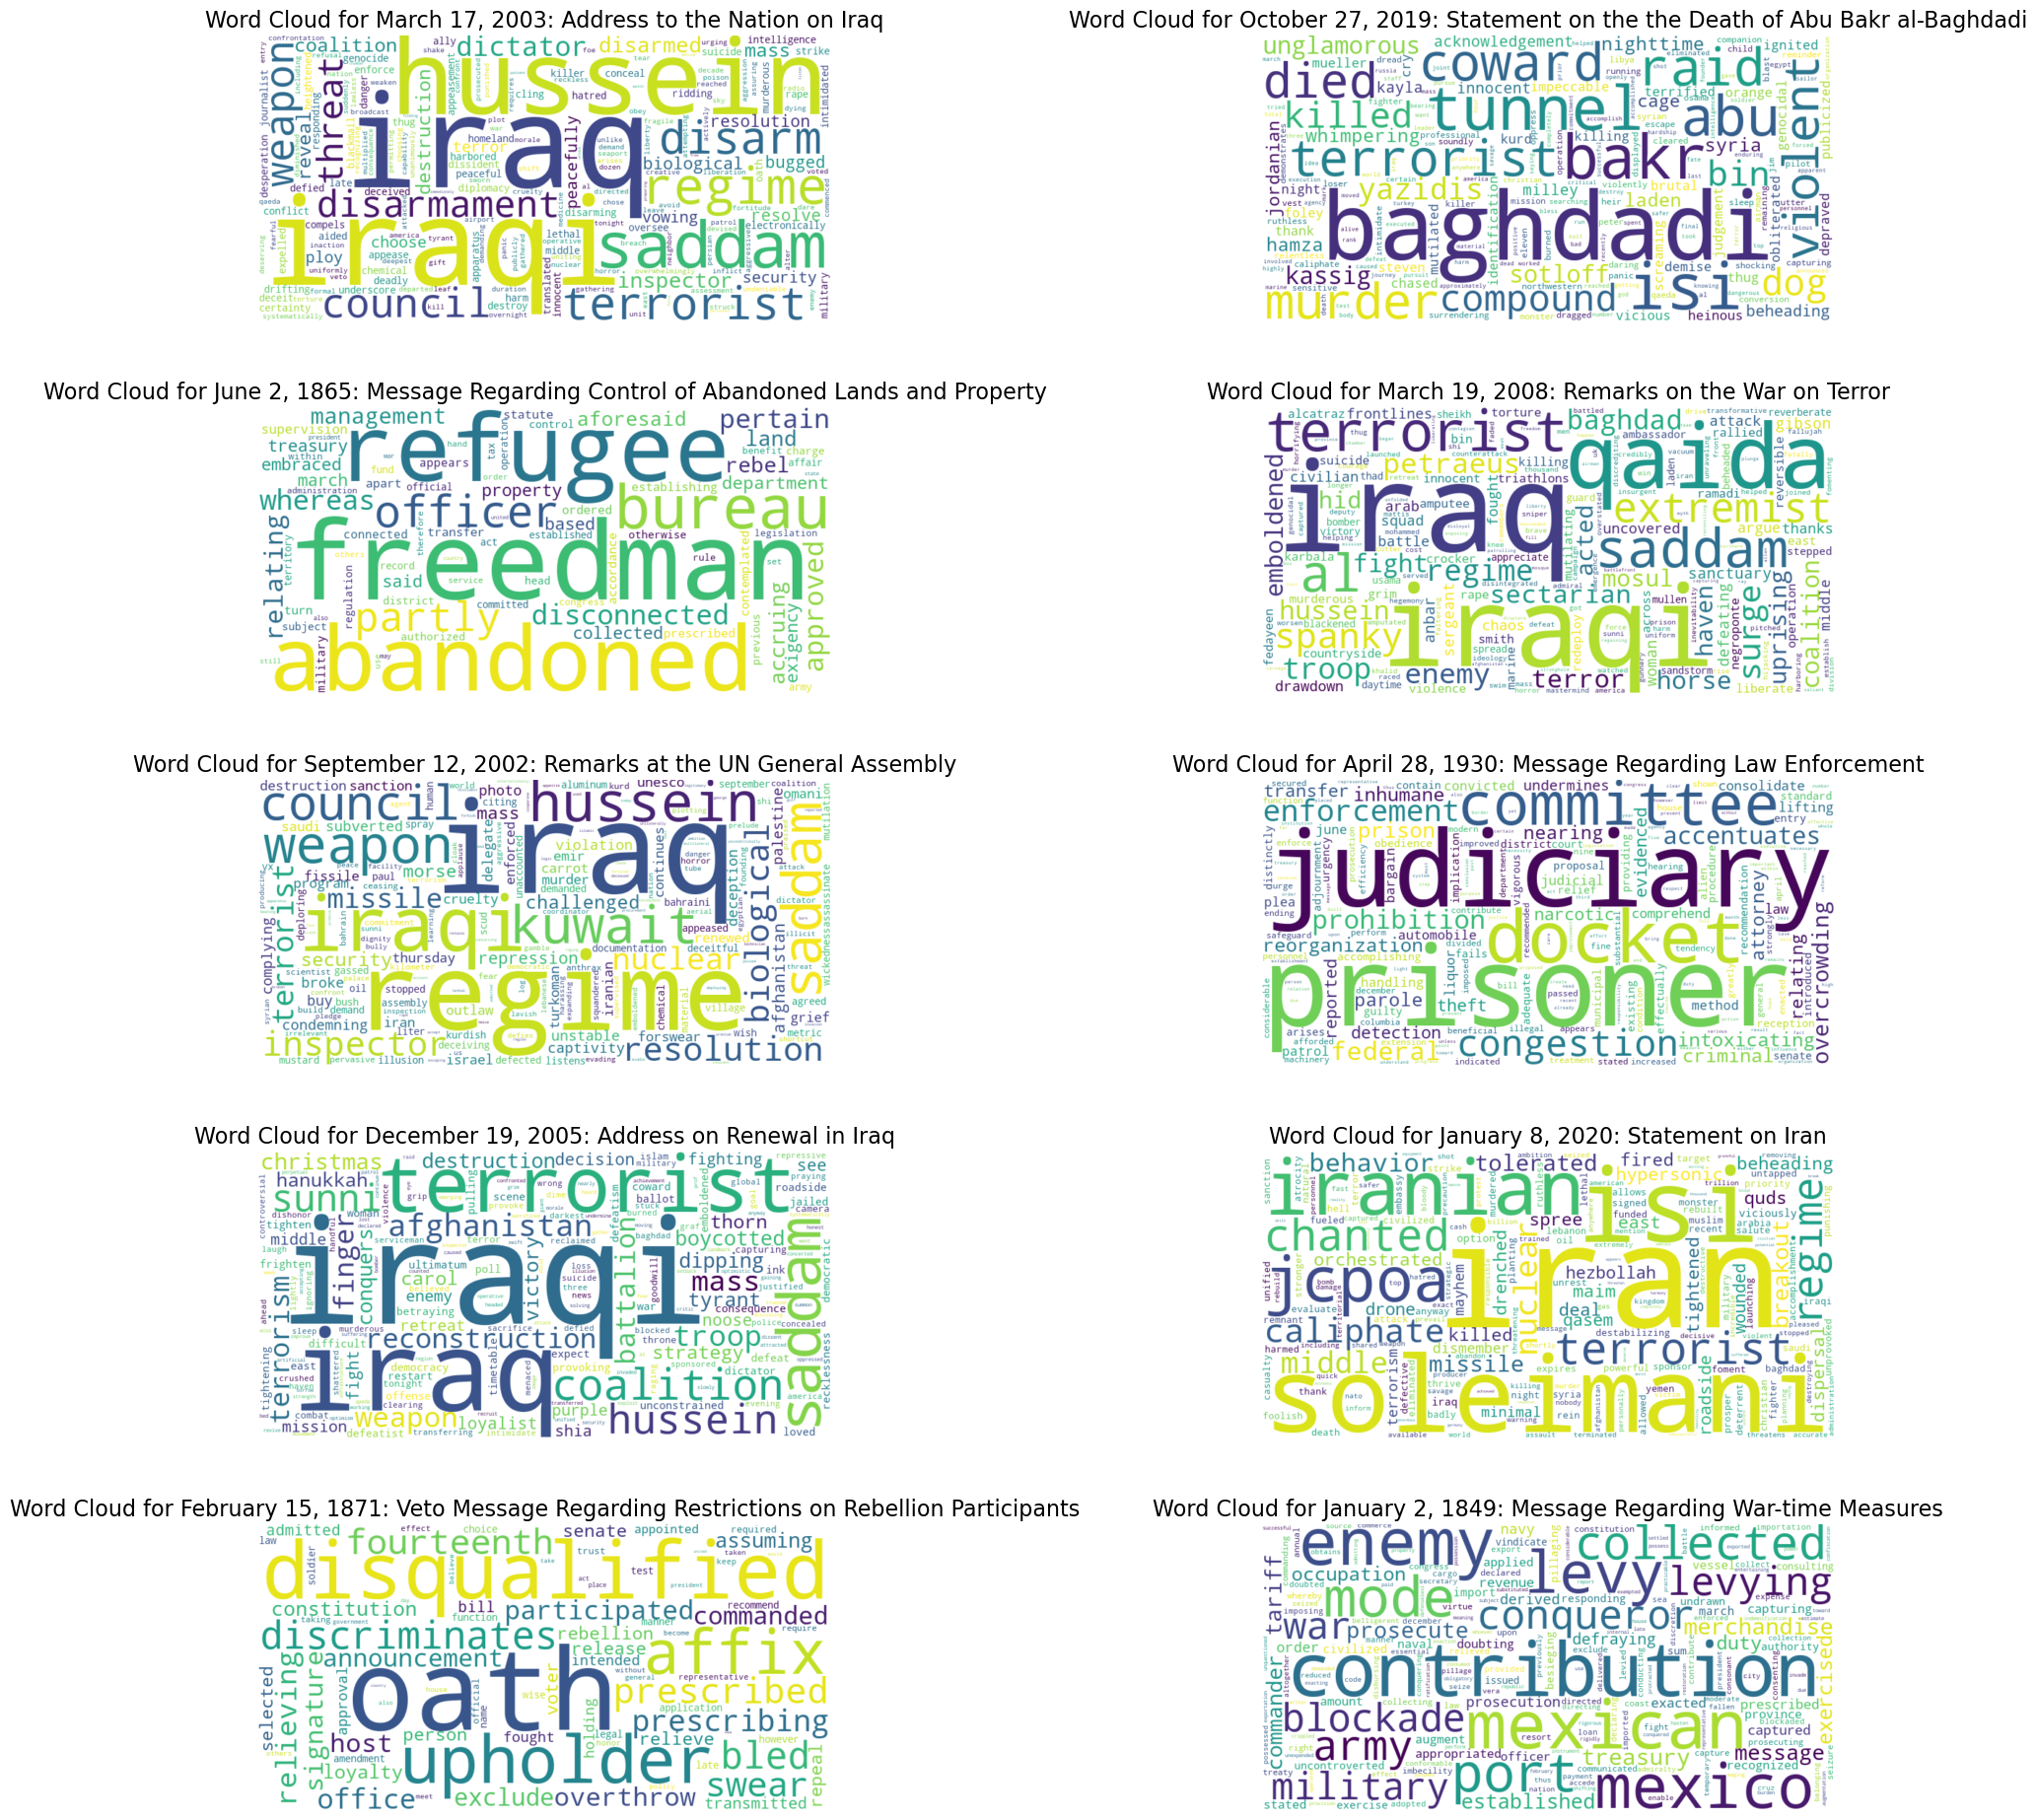

In [96]:
# Get the top 10 saddest speeches
saddest_speeches = sorted(sentiments, key=sentiments.get, reverse=False)[:10]

# Filter the tfidf_speech dictionary to include only the top 10 saddest speeches
top_tfidf_speeches = {speech: tfidf_speech[speech] for speech in saddest_speeches}

# Create word clouds for the top 10 saddest speeches
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
for i, (speech, tfidf) in enumerate(top_tfidf_speeches.items()):
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, collocations=False, background_color='white').generate_from_frequencies(tfidf)
    ax = plt.subplot(5, 2, i + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"Word Cloud for {speech}", fontsize=16)

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.3, wspace=0.3)
plt.show()

In [97]:
# TODO
# get happiest and saddest parties and wordclouds?
# get happiest and saddest louvain communities and wordclouds?

origin of gdp data: https://www.measuringworth.com/datasets/

In [98]:
# add gdps to the speeches
gdp_data = pd.read_csv('USGDP_1790-2024.csv', skiprows=2)
# change name of 2nd column 
gdp_data.columns.values[1] = 'Real GDP per capita (dollars)'

# add as attribute to speeches based on year of their date
for speech in speeches:
    year = speech['date'].year
    gdp = gdp_data[gdp_data['Year'] == year]['Real GDP per capita (dollars)']
    if not gdp.empty:
        speech['gdp'] = float(gdp.values[0].replace(',', ''))
    else:
        speech['gdp'] = None

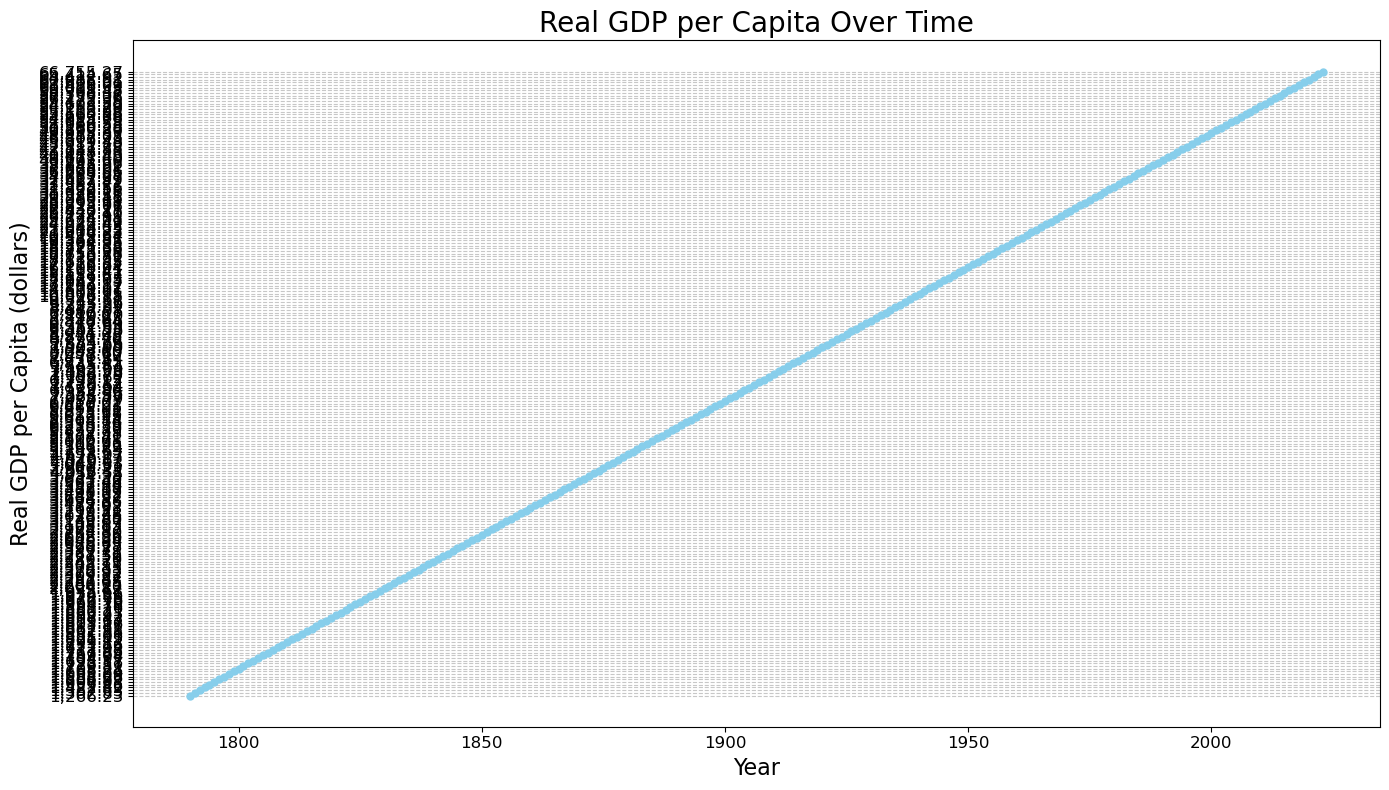

In [99]:
# plot the GDP over time
years = gdp_data['Year']
gdps = gdp_data['Real GDP per capita (dollars)']
plt.figure(figsize=(14, 8))
plt.plot(years, gdps, color='skyblue', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.title('Real GDP per Capita Over Time', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Real GDP per Capita (dollars)', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

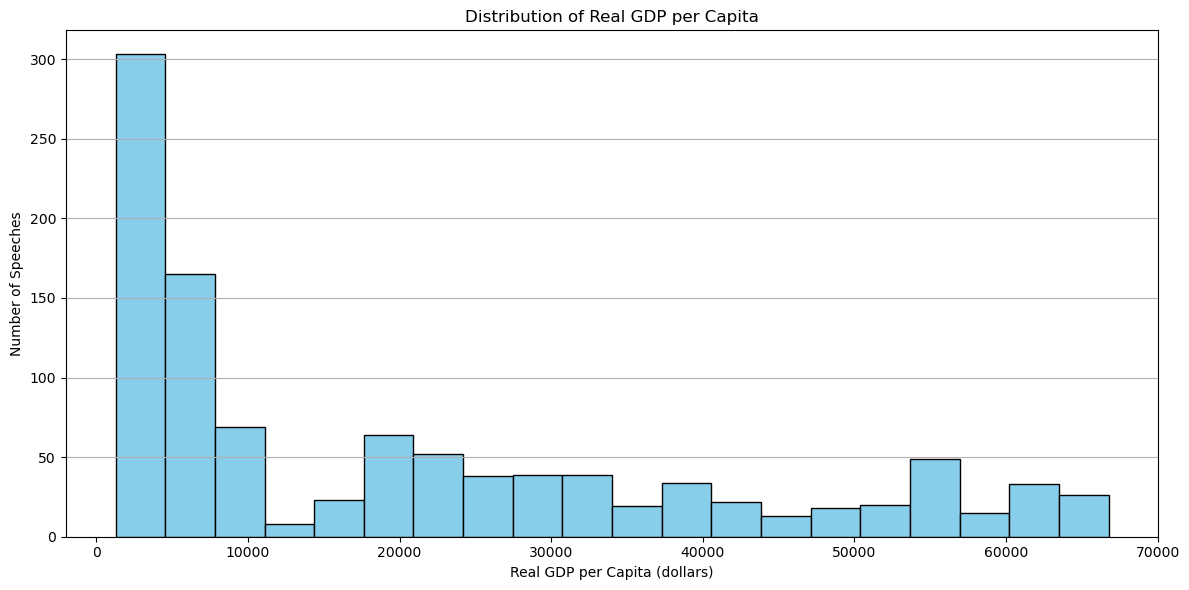

In [100]:
# bar plot of gdps distribution over speeches
plt.figure(figsize=(12, 6))
gdps = [speech['gdp'] for speech in speeches if speech['gdp'] is not None]
plt.hist(gdps, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Real GDP per Capita')
plt.xlabel('Real GDP per Capita (dollars)')
plt.ylabel('Number of Speeches')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

TODO:
Calculate gdp growth per presidential mandate

correlate growth with sentiments

In [ ]:
# Correlate speech sentiment with GDP data
correlation = gdp_data['gdp_growth'].corr(pd.Series(sentiments))
print(f"Sentiment-GDP Correlation: {correlation}")

In [ ]:
# TODO
# find more data to correlate with sentiment